# population-inference
notebook for running vectorised inference over a population of hares or emus

In [1]:
#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os
##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk



os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

#tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2024-09-19 12:49:03.188510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 12:49:03.200234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 12:49:03.203884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 12:49:03.213480: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 12:49:03.811989: W tensorflow/compiler/tf2

## import neural network

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


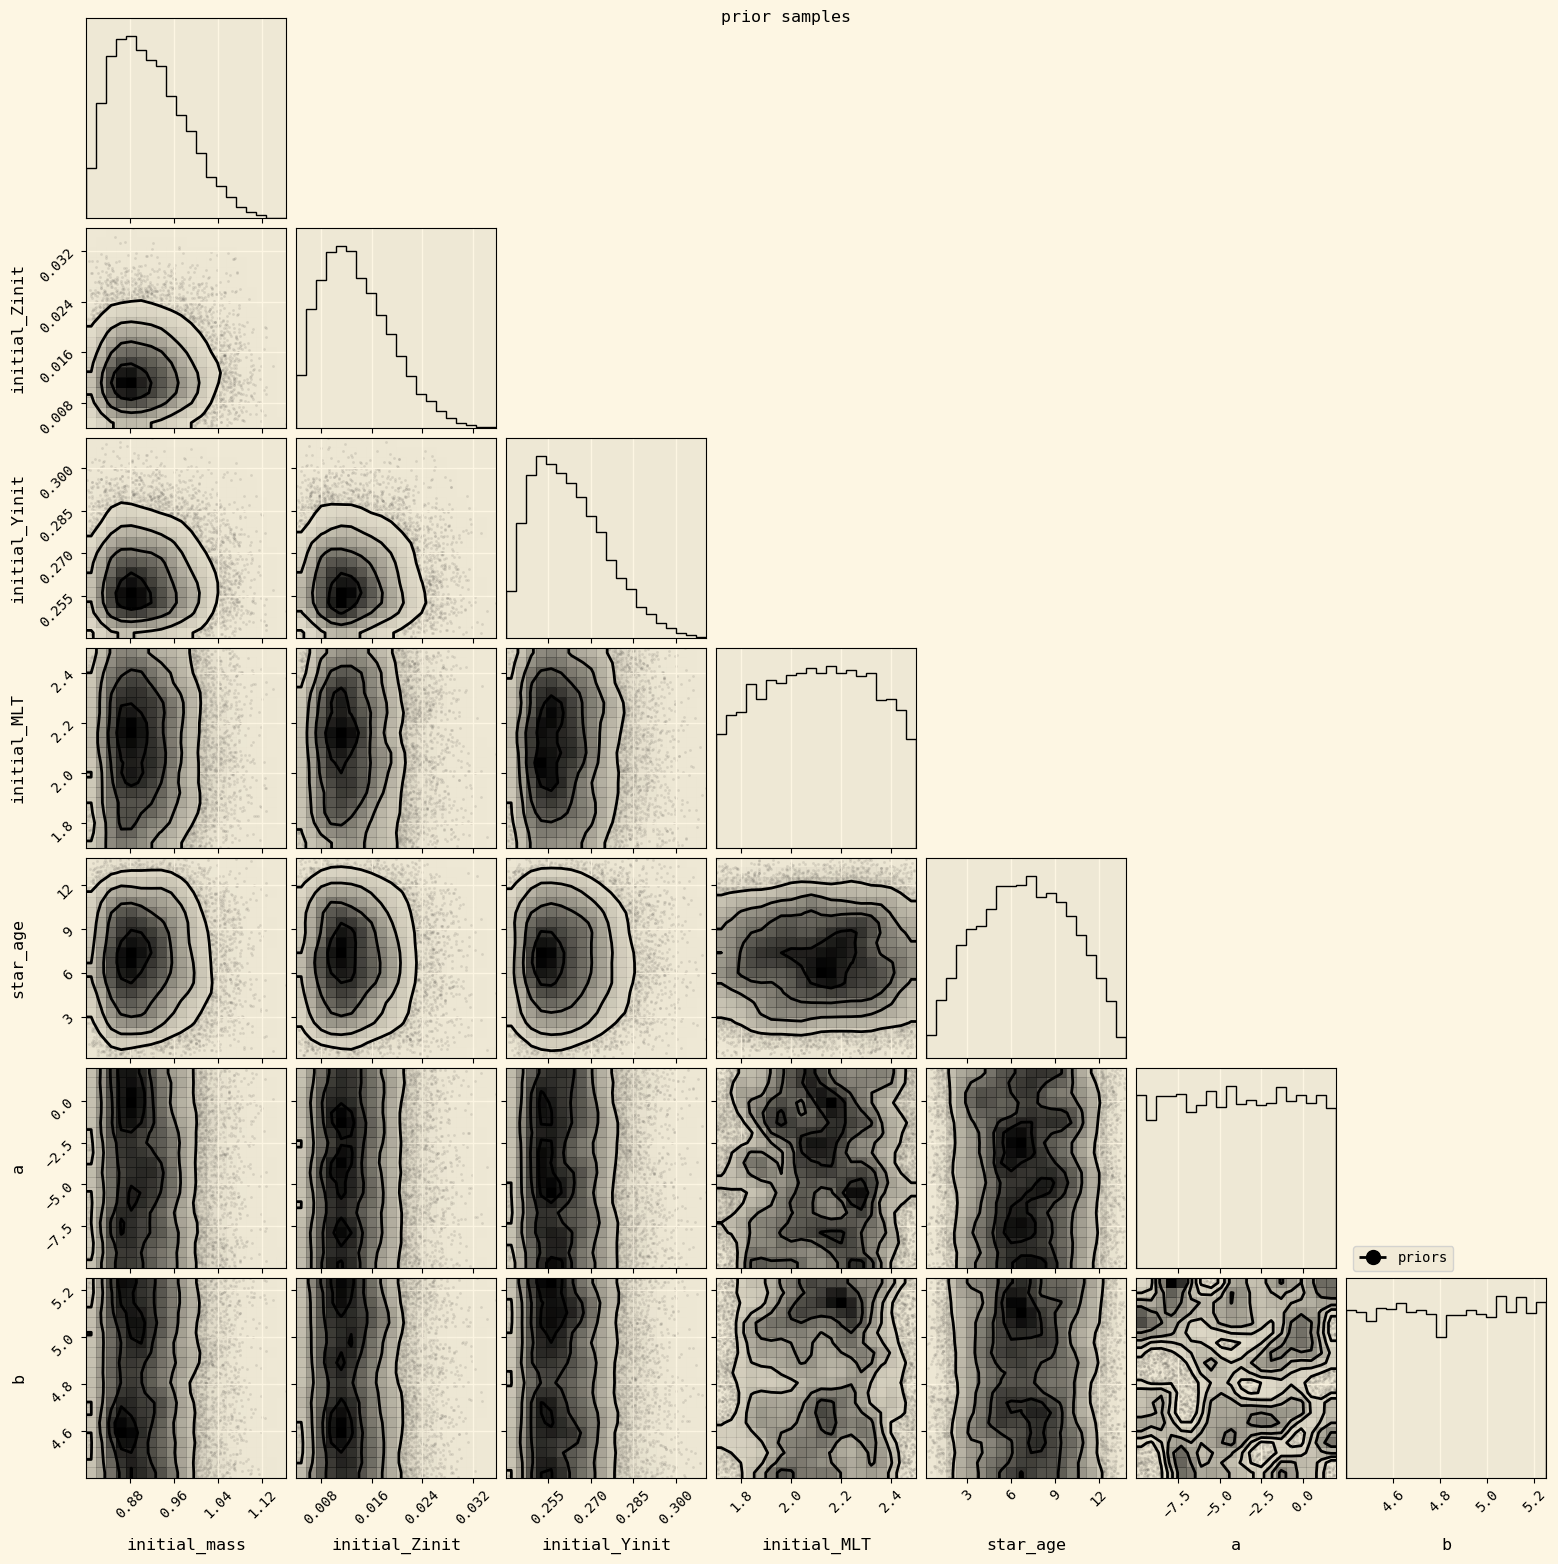

In [3]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [4]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)
    
ndraw_min=128
ndraw_max=4096

for obs_idx in range(1):
    for hare_idx in range(1):
        path = f'surf_form/hare{hare_idx}/obs{obs_idx}/'

        hare_df = pd.read_json(f"surf_form/hare{hare_idx}/hare{hare_idx}.json")
        nu_max = hare_df["nu_max"].values[0]
        
        hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
        hare_uncs = pd.read_json(path+'uncs.json')
        hare_uncs_array = hare_uncs.values[0]
    
        n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
        n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))
    
        sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
        sigma_nn_mask[:3] = True
        sigma_nn_mask[n_min-3:n_max-2] = True
    
        sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]
    
        sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))
    
        sigma = sigma_nn_cropped + sigma_obs
    
        sigma_inv = np.linalg.inv(sigma)
    
        _, log_sigma_det = np.linalg.slogdet(sigma)
        
        outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
        
        sampler = ultra_ns_vector_surface(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
        results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=64, frac_remain=.1)
        with open(path+'/samples.pkl', 'wb') as fp:
            pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
        sampler.cleanup()
        del results

DEBUG:ultranest:ReactiveNestedSampler: dims=7+0, resume=False, log_dir=None, backend=hdf5, vectorized=True, nbootstraps=30, ndraw=128..4096


[ultranest] Sampling 64 live points from prior ...


INFO:ultranest:Sampling 64 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.10, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=64, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 64.0), (inf, 64.0)]


DEBUG:ultranest:iteration=0, ncalls=192, regioncalls=128, ndraw=128, logz=-inf, remainder_fraction=100.0000%, Lmin=-1468116255.04, Lmax=-75.05


DEBUG:ultranest:iteration=6, ncalls=192, regioncalls=128, ndraw=128, logz=-4406190.62, remainder_fraction=100.0000%, Lmin=-3929403.96, Lmax=-75.05


DEBUG:ultranest:iteration=12, ncalls=192, regioncalls=128, ndraw=128, logz=-3187474.82, remainder_fraction=100.0000%, Lmin=-3186137.05, Lmax=-75.05


DEBUG:ultranest:iteration=18, ncalls=192, regioncalls=128, ndraw=128, logz=-2357881.59, remainder_fraction=100.0000%, Lmin=-2294808.85, Lmax=-75.05


DEBUG:ultranest:iteration=24, ncalls=192, regioncalls=128, ndraw=128, logz=-1965992.31, remainder_fraction=100.0000%, Lmin=-1928271.42, Lmax=-75.05
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([63,  1]))


DEBUG:ultranest:iteration=30, ncalls=192, regioncalls=128, ndraw=128, logz=-1784878.48, remainder_fraction=100.0000%, Lmin=-1774595.59, Lmax=-75.05


DEBUG:ultranest:iteration=36, ncalls=192, regioncalls=128, ndraw=128, logz=-1335023.73, remainder_fraction=100.0000%, Lmin=-1329363.20, Lmax=-75.05


DEBUG:ultranest:iteration=42, ncalls=192, regioncalls=128, ndraw=128, logz=-1118187.53, remainder_fraction=100.0000%, Lmin=-1090434.57, Lmax=-75.05


DEBUG:ultranest:iteration=45, ncalls=192, regioncalls=128, ndraw=128, logz=-1086626.39, remainder_fraction=100.0000%, Lmin=-1083235.00, Lmax=-75.05


DEBUG:ultranest:iteration=48, ncalls=192, regioncalls=128, ndraw=128, logz=-1063091.17, remainder_fraction=100.0000%, Lmin=-1055496.16, Lmax=-75.05


DEBUG:ultranest:iteration=54, ncalls=192, regioncalls=128, ndraw=128, logz=-950845.83, remainder_fraction=100.0000%, Lmin=-946916.98, Lmax=-75.05


DEBUG:ultranest:iteration=60, ncalls=192, regioncalls=128, ndraw=128, logz=-858936.33, remainder_fraction=100.0000%, Lmin=-807305.25, Lmax=-75.05


DEBUG:ultranest:iteration=66, ncalls=192, regioncalls=128, ndraw=128, logz=-729850.32, remainder_fraction=100.0000%, Lmin=-670481.31, Lmax=-75.05


DEBUG:ultranest:iteration=72, ncalls=304, regioncalls=256, ndraw=128, logz=-549770.11, remainder_fraction=100.0000%, Lmin=-535640.74, Lmax=-75.05


DEBUG:ultranest:iteration=78, ncalls=304, regioncalls=256, ndraw=128, logz=-460241.64, remainder_fraction=100.0000%, Lmin=-456050.75, Lmax=-75.05


DEBUG:ultranest:iteration=84, ncalls=304, regioncalls=256, ndraw=128, logz=-418899.39, remainder_fraction=100.0000%, Lmin=-374082.26, Lmax=-75.05


DEBUG:ultranest:iteration=90, ncalls=304, regioncalls=256, ndraw=128, logz=-340090.33, remainder_fraction=100.0000%, Lmin=-331777.60, Lmax=-75.05


DEBUG:ultranest:iteration=96, ncalls=304, regioncalls=256, ndraw=128, logz=-305228.89, remainder_fraction=100.0000%, Lmin=-301936.01, Lmax=-75.05


DEBUG:ultranest:iteration=102, ncalls=304, regioncalls=256, ndraw=128, logz=-240345.23, remainder_fraction=100.0000%, Lmin=-239304.86, Lmax=-75.05


DEBUG:ultranest:iteration=108, ncalls=398, regioncalls=384, ndraw=128, logz=-205201.44, remainder_fraction=100.0000%, Lmin=-199829.37, Lmax=-75.05


DEBUG:ultranest:iteration=114, ncalls=398, regioncalls=384, ndraw=128, logz=-173661.79, remainder_fraction=100.0000%, Lmin=-164941.52, Lmax=-75.05


DEBUG:ultranest:iteration=120, ncalls=398, regioncalls=384, ndraw=128, logz=-136899.71, remainder_fraction=100.0000%, Lmin=-130487.79, Lmax=-75.05


DEBUG:ultranest:iteration=126, ncalls=398, regioncalls=384, ndraw=128, logz=-112741.05, remainder_fraction=100.0000%, Lmin=-108958.02, Lmax=-75.05


DEBUG:ultranest:iteration=132, ncalls=446, regioncalls=512, ndraw=128, logz=-96086.42, remainder_fraction=100.0000%, Lmin=-93298.30, Lmax=-75.05


DEBUG:ultranest:iteration=135, ncalls=446, regioncalls=512, ndraw=128, logz=-88081.45, remainder_fraction=100.0000%, Lmin=-87646.78, Lmax=-75.05


DEBUG:ultranest:iteration=138, ncalls=446, regioncalls=512, ndraw=128, logz=-80673.00, remainder_fraction=100.0000%, Lmin=-70774.64, Lmax=-75.05


DEBUG:ultranest:iteration=144, ncalls=502, regioncalls=640, ndraw=128, logz=-61658.05, remainder_fraction=100.0000%, Lmin=-60515.04, Lmax=-75.05


DEBUG:ultranest:iteration=150, ncalls=502, regioncalls=640, ndraw=128, logz=-52365.82, remainder_fraction=100.0000%, Lmin=-51235.79, Lmax=-75.05


DEBUG:ultranest:iteration=156, ncalls=545, regioncalls=768, ndraw=128, logz=-41970.93, remainder_fraction=100.0000%, Lmin=-41488.13, Lmax=-75.05


DEBUG:ultranest:iteration=162, ncalls=587, regioncalls=896, ndraw=128, logz=-33420.04, remainder_fraction=100.0000%, Lmin=-33124.94, Lmax=-75.05


DEBUG:ultranest:iteration=165, ncalls=587, regioncalls=896, ndraw=128, logz=-32318.15, remainder_fraction=100.0000%, Lmin=-30071.23, Lmax=-75.05


DEBUG:ultranest:iteration=168, ncalls=587, regioncalls=896, ndraw=128, logz=-25203.36, remainder_fraction=100.0000%, Lmin=-24007.42, Lmax=-75.05


DEBUG:ultranest:iteration=174, ncalls=630, regioncalls=1024, ndraw=128, logz=-20834.40, remainder_fraction=100.0000%, Lmin=-20767.70, Lmax=-53.35


DEBUG:ultranest:iteration=180, ncalls=630, regioncalls=1024, ndraw=128, logz=-15907.48, remainder_fraction=100.0000%, Lmin=-15303.78, Lmax=-53.35


DEBUG:ultranest:iteration=186, ncalls=651, regioncalls=1152, ndraw=128, logz=-11739.97, remainder_fraction=100.0000%, Lmin=-11707.60, Lmax=-53.35


DEBUG:ultranest:iteration=192, ncalls=680, regioncalls=1280, ndraw=128, logz=-10001.24, remainder_fraction=100.0000%, Lmin=-9990.11, Lmax=-53.35


DEBUG:ultranest:iteration=195, ncalls=680, regioncalls=1280, ndraw=128, logz=-9280.97, remainder_fraction=100.0000%, Lmin=-9105.93, Lmax=-53.35


DEBUG:ultranest:iteration=198, ncalls=712, regioncalls=1408, ndraw=128, logz=-8857.32, remainder_fraction=100.0000%, Lmin=-8785.55, Lmax=-53.35


DEBUG:ultranest:iteration=204, ncalls=740, regioncalls=1536, ndraw=128, logz=-7581.65, remainder_fraction=100.0000%, Lmin=-7371.48, Lmax=-53.35


DEBUG:ultranest:iteration=210, ncalls=774, regioncalls=1664, ndraw=128, logz=-5844.16, remainder_fraction=100.0000%, Lmin=-5719.65, Lmax=-53.35


DEBUG:ultranest:iteration=216, ncalls=819, regioncalls=1920, ndraw=128, logz=-5077.56, remainder_fraction=100.0000%, Lmin=-5009.78, Lmax=-53.35


DEBUG:ultranest:iteration=222, ncalls=819, regioncalls=1920, ndraw=128, logz=-4601.12, remainder_fraction=100.0000%, Lmin=-4496.48, Lmax=-53.35


DEBUG:ultranest:iteration=225, ncalls=842, regioncalls=2048, ndraw=128, logz=-4302.70, remainder_fraction=100.0000%, Lmin=-4202.85, Lmax=-53.35


DEBUG:ultranest:iteration=228, ncalls=889, regioncalls=2304, ndraw=128, logz=-3870.11, remainder_fraction=100.0000%, Lmin=-3756.81, Lmax=-53.35


DEBUG:ultranest:iteration=234, ncalls=941, regioncalls=2560, ndraw=128, logz=-3477.13, remainder_fraction=100.0000%, Lmin=-3125.35, Lmax=-42.30


DEBUG:ultranest:iteration=240, ncalls=989, regioncalls=2816, ndraw=128, logz=-2772.19, remainder_fraction=100.0000%, Lmin=-2532.87, Lmax=-42.30


DEBUG:ultranest:iteration=246, ncalls=1064, regioncalls=3200, ndraw=128, logz=-2364.70, remainder_fraction=100.0000%, Lmin=-2337.38, Lmax=-42.30


DEBUG:ultranest:iteration=252, ncalls=1118, regioncalls=3456, ndraw=128, logz=-2113.60, remainder_fraction=100.0000%, Lmin=-2001.98, Lmax=-42.30


DEBUG:ultranest:iteration=255, ncalls=1118, regioncalls=3456, ndraw=128, logz=-1964.85, remainder_fraction=100.0000%, Lmin=-1834.45, Lmax=-17.05


DEBUG:ultranest:iteration=258, ncalls=1150, regioncalls=3584, ndraw=128, logz=-1721.47, remainder_fraction=100.0000%, Lmin=-1639.85, Lmax=-17.05


DEBUG:ultranest:iteration=264, ncalls=1295, regioncalls=4224, ndraw=128, logz=-1469.12, remainder_fraction=100.0000%, Lmin=-1446.13, Lmax=-17.05


DEBUG:ultranest:iteration=270, ncalls=1340, regioncalls=4480, ndraw=128, logz=-1346.21, remainder_fraction=100.0000%, Lmin=-1285.06, Lmax=-17.05


DEBUG:ultranest:iteration=276, ncalls=1465, regioncalls=4992, ndraw=128, logz=-1084.99, remainder_fraction=100.0000%, Lmin=-1061.96, Lmax=-17.05


DEBUG:ultranest:iteration=282, ncalls=1491, regioncalls=5120, ndraw=128, logz=-840.09, remainder_fraction=100.0000%, Lmin=-802.74, Lmax=-17.05
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([63,  1]))


DEBUG:ultranest:iteration=288, ncalls=1565, regioncalls=5504, ndraw=128, logz=-715.36, remainder_fraction=100.0000%, Lmin=-694.90, Lmax=-17.05


DEBUG:ultranest:iteration=294, ncalls=1659, regioncalls=6016, ndraw=128, logz=-614.29, remainder_fraction=100.0000%, Lmin=-603.76, Lmax=-17.05


DEBUG:ultranest:iteration=300, ncalls=1809, regioncalls=6784, ndraw=128, logz=-568.41, remainder_fraction=100.0000%, Lmin=-548.49, Lmax=-17.05


DEBUG:ultranest:iteration=306, ncalls=1919, regioncalls=7296, ndraw=128, logz=-490.17, remainder_fraction=100.0000%, Lmin=-469.34, Lmax=-17.05


DEBUG:ultranest:iteration=312, ncalls=2026, regioncalls=7808, ndraw=128, logz=-433.01, remainder_fraction=100.0000%, Lmin=-421.81, Lmax=-17.05
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([63,  1]))


DEBUG:ultranest:iteration=318, ncalls=2249, regioncalls=8832, ndraw=128, logz=-342.93, remainder_fraction=100.0000%, Lmin=-319.63, Lmax=-17.05


DEBUG:ultranest:iteration=324, ncalls=2330, regioncalls=9216, ndraw=128, logz=-308.22, remainder_fraction=100.0000%, Lmin=-298.50, Lmax=-17.05
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2, 3]), array([62,  1,  1]))


DEBUG:ultranest:iteration=330, ncalls=2451, regioncalls=9728, ndraw=128, logz=-280.89, remainder_fraction=100.0000%, Lmin=-270.93, Lmax=-17.05


DEBUG:ultranest:iteration=336, ncalls=2624, regioncalls=10496, ndraw=128, logz=-266.90, remainder_fraction=100.0000%, Lmin=-256.12, Lmax=-17.05


DEBUG:ultranest:iteration=342, ncalls=2833, regioncalls=11520, ndraw=128, logz=-220.15, remainder_fraction=100.0000%, Lmin=-178.53, Lmax=-17.05
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([63,  1]))


DEBUG:ultranest:iteration=348, ncalls=3055, regioncalls=12544, ndraw=128, logz=-157.10, remainder_fraction=100.0000%, Lmin=-144.71, Lmax=-17.05


DEBUG:ultranest:iteration=354, ncalls=3385, regioncalls=14080, ndraw=128, logz=-143.52, remainder_fraction=100.0000%, Lmin=-130.28, Lmax=-17.05


DEBUG:ultranest:iteration=360, ncalls=3962, regioncalls=16640, ndraw=128, logz=-120.07, remainder_fraction=100.0000%, Lmin=-110.30, Lmax=-17.05


DEBUG:ultranest:iteration=366, ncalls=4274, regioncalls=18048, ndraw=128, logz=-113.58, remainder_fraction=100.0000%, Lmin=-104.07, Lmax=-17.05


DEBUG:ultranest:iteration=368, ncalls=4626, regioncalls=19712, ndraw=128, logz=-112.56, remainder_fraction=100.0000%, Lmin=-103.25, Lmax=-17.05


DEBUG:ultranest:iteration=372, ncalls=5078, regioncalls=21760, ndraw=128, logz=-109.37, remainder_fraction=100.0000%, Lmin=-96.38, Lmax=-17.05
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([63,  1]))


DEBUG:ultranest:iteration=377, ncalls=5461, regioncalls=23424, ndraw=128, logz=-102.05, remainder_fraction=100.0000%, Lmin=-92.24, Lmax=-17.05


DEBUG:ultranest:iteration=378, ncalls=5528, regioncalls=23680, ndraw=128, logz=-101.47, remainder_fraction=100.0000%, Lmin=-86.95, Lmax=-17.05


DEBUG:ultranest:iteration=384, ncalls=5735, regioncalls=24576, ndraw=128, logz=-93.85, remainder_fraction=100.0000%, Lmin=-81.27, Lmax=-17.05


DEBUG:ultranest:iteration=389, ncalls=6240, regioncalls=26752, ndraw=128, logz=-87.51, remainder_fraction=100.0000%, Lmin=-77.71, Lmax=-17.05


DEBUG:ultranest:iteration=390, ncalls=6360, regioncalls=27392, ndraw=128, logz=-87.01, remainder_fraction=100.0000%, Lmin=-77.66, Lmax=-17.05


DEBUG:ultranest:iteration=392, ncalls=6713, regioncalls=29312, ndraw=128, logz=-85.10, remainder_fraction=100.0000%, Lmin=-73.43, Lmax=-17.05


KeyboardInterrupt: 

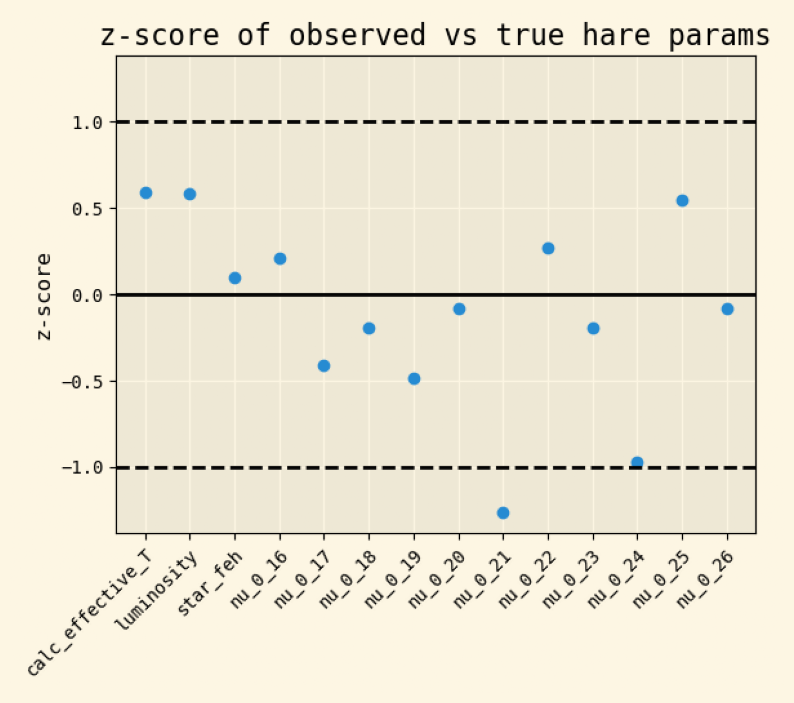

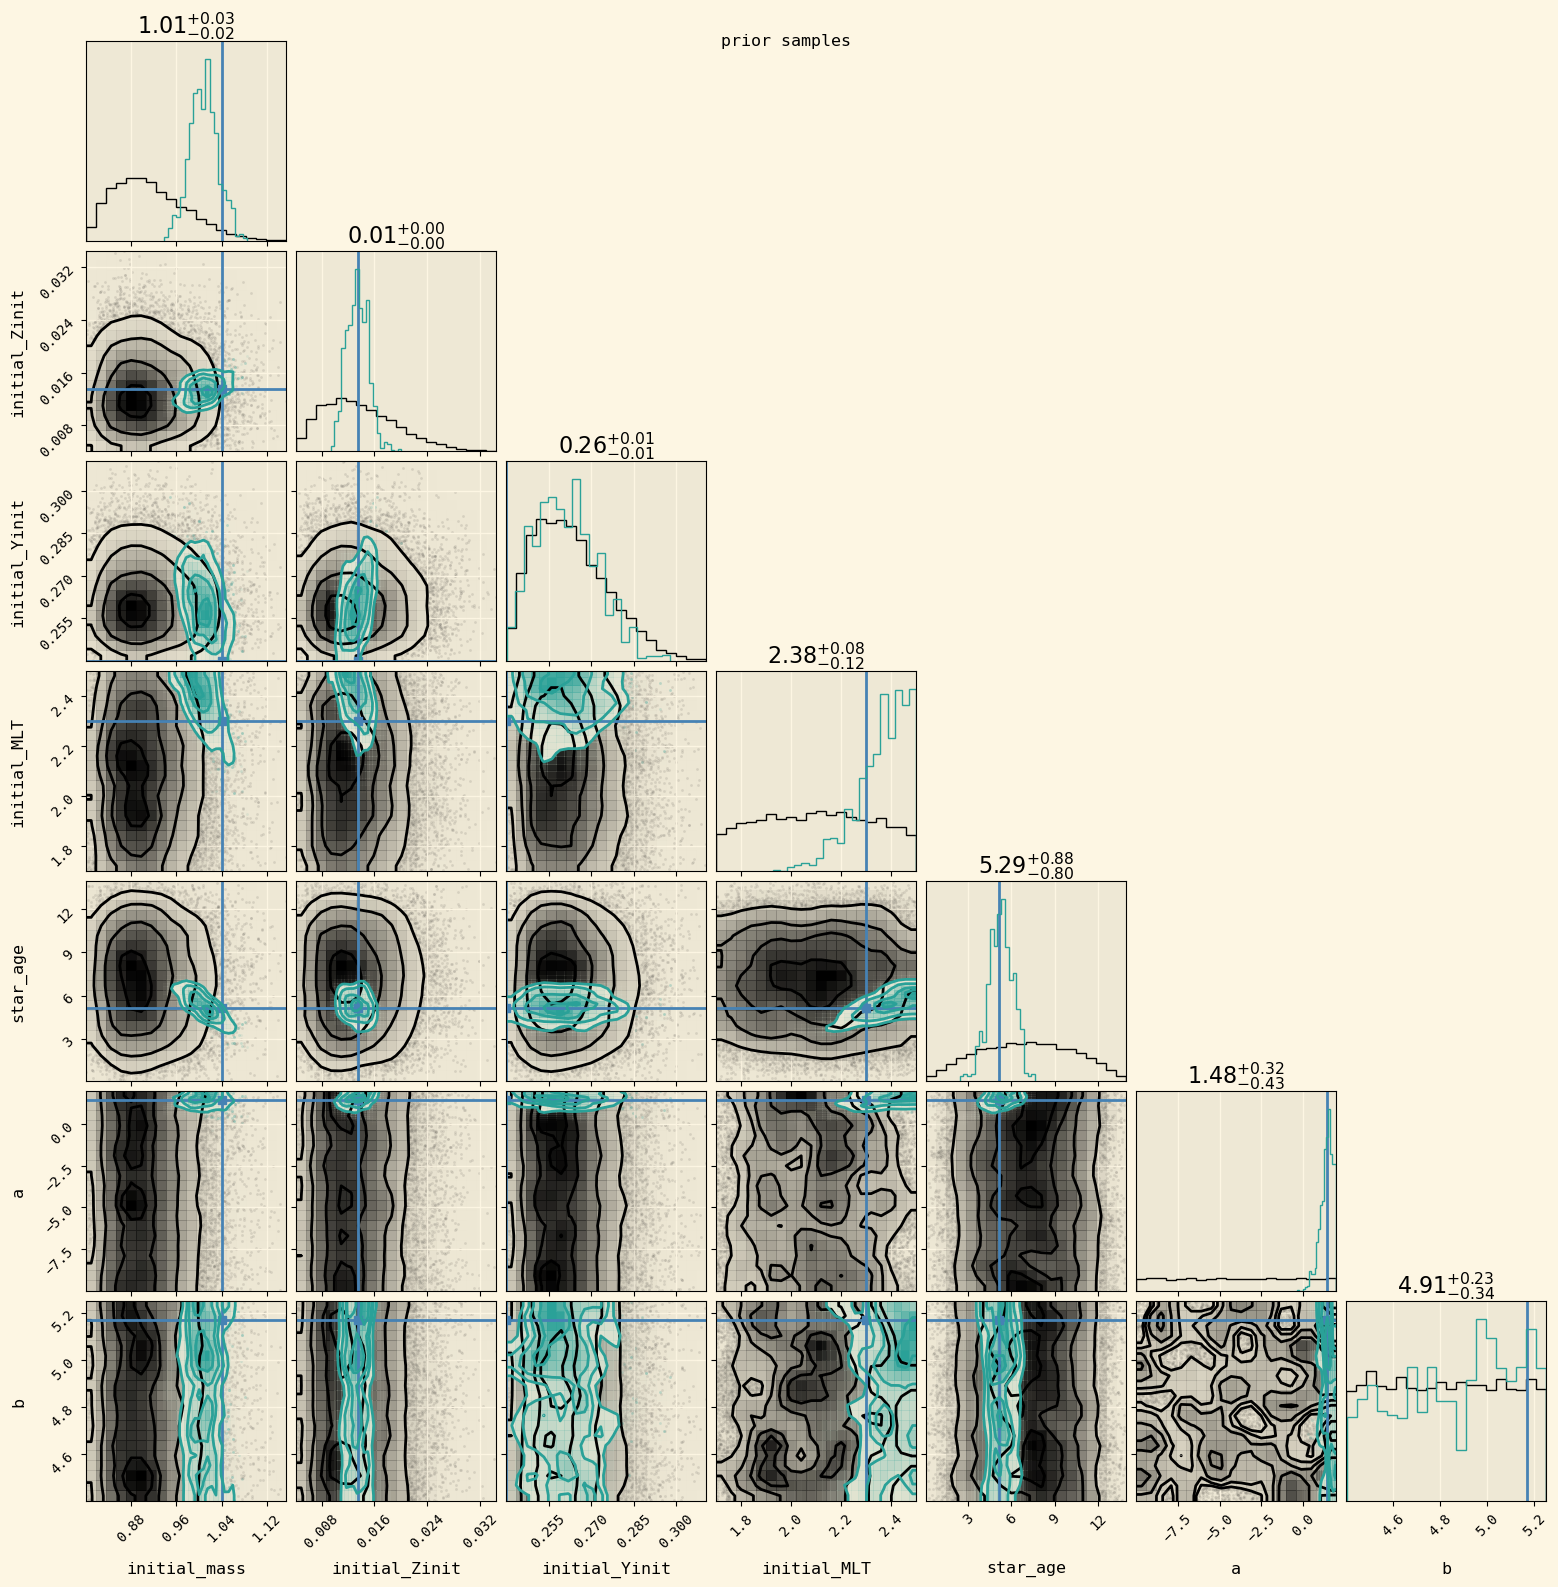

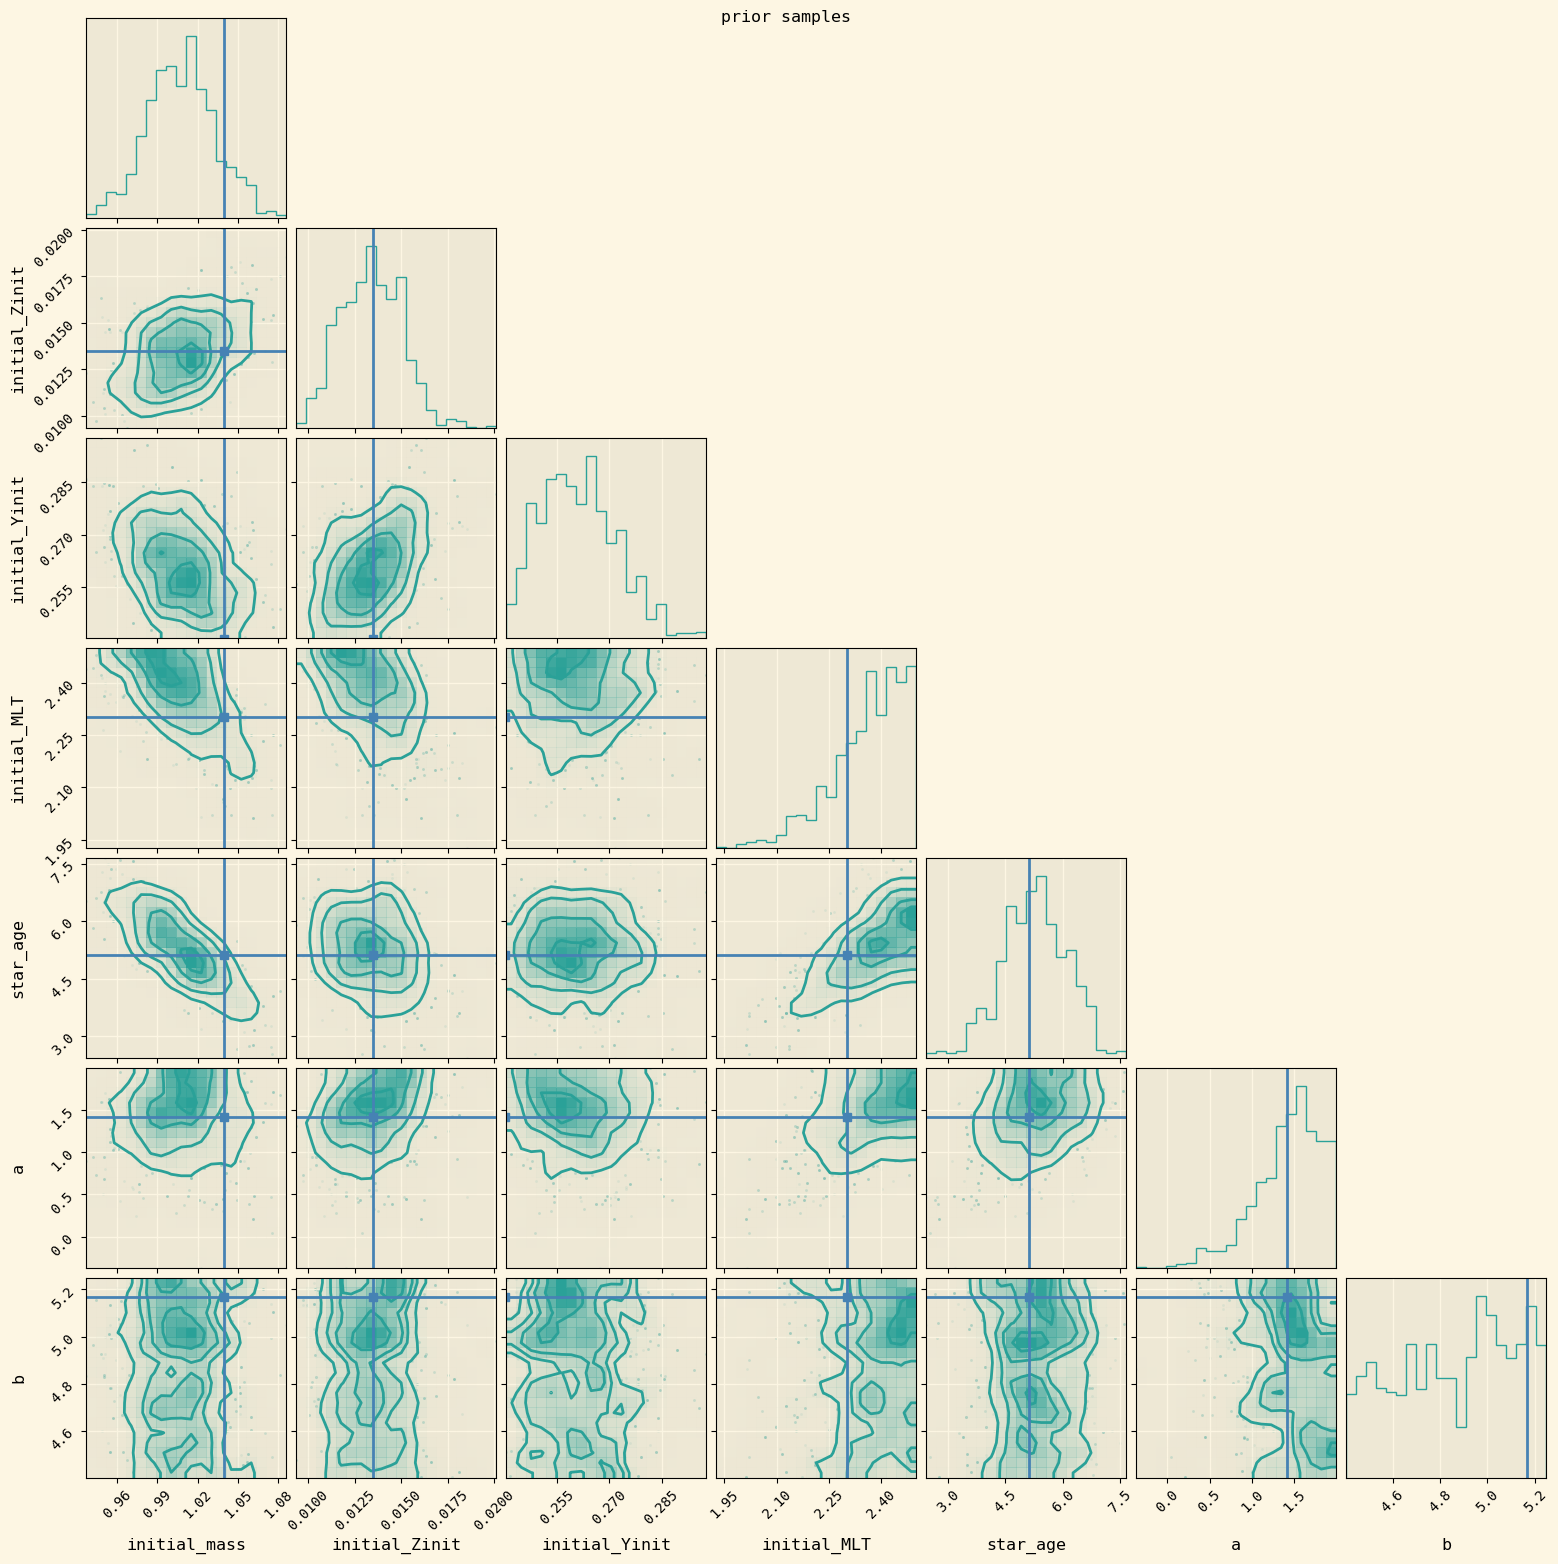

In [12]:
def inspect_hare(hare_idx, obs_idx):
    path = f'surf_form/hare{hare_idx}'
    image = plt.imread(path+f'/obs{obs_idx}/zscore_plot.png')

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image)
    ax.axis('off')

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    hare_df = pd.read_json(path+f'/obs{obs_idx}/obs{obs_idx}.json')[labels]

    
    with open(path+f'/obs{obs_idx}/samples.pkl', 'rb') as fp:
         samples = pickle.load(fp)

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, truths = hare_df.values[0], color=corner_color, hist_kwargs={'density':True}, smooth=True);
    corner.corner(samples['samples'], fig=figure, color=colors[1],hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle('prior samples')
    plt.show()

    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(samples['samples'], labels = labels, truths = hare_df.values[0], color=colors[1], hist_kwargs={'density':True}, smooth=True);
    plt.suptitle('prior samples')
    plt.show()

    
inspect_hare(0,0)